# w207 Final Project: Mechanisms of Action

## Introduction

In pharamacology, mechanisms of actions are the specific biochemical processes that occur when pharmaceutical products interact with human cells. In particular, mechanisms of action usually refer to a specific molecular process which creates a certain outcome in a cell.

The goal of this project is to predict the mechanism of action for different chemical compounds.

This is a multi-label classification problem, where we have 207 different binary targets that describe various forms a cell responses to a specific drug.

#### Import needed packages

In [1]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

#  SK-learn libraries
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# To deal with imbalenced data
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler

#tensorflow libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers 





/Users/daniellampert/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploratory Data Analysis

In [2]:
#load data

#uncomment this chunk when running on kaggle
#train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")
#train_targets_non_scored = pd.read_csv("/kaggle/input/lish-moa/train_targets_nonscored.csv")
#train_targets_scored = pd.read_csv("/kaggle/input/lish-moa/train_targets_scored.csv")
#test_features = pd.read_csv("/kaggle/input/lish-moa/test_features.csv")
#test_index = test_features.index
#path = '/kaggle/input/lish-moa/sample_submission.csv'
#sample_sub = pd.read_csv(path)

#comment this chunk when running on kaggle
train_features = pd.read_csv("train_features.csv")
train_targets_non_scored = pd.read_csv("train_targets_nonscored.csv")
train_targets_scored = pd.read_csv("train_targets_scored.csv")
test_features = pd.read_csv("test_features.csv")
test_index = test_features.index
path = 'sample_submission.csv'
sample_sub = pd.read_csv(path)

We are given 4 datasets: 

- train_features: training features
- train_targets_non_scored: training targets (containing those not used in scoring)
- train_targets_scored: training targets (only those used in scoring)
- test_features: test set that will be used for evaluation

### Features


- sig_id is the sample id features
- features that start with g are for gene expression
- features that start with c are cell viability features
- cp_type is a binary feature that indicates whether a sample was treated with a compound or with a control pertubation
- cp_dose indicates if the treatment was with a high or low dose. D1 for low, D2 for high.

In [3]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [6]:
print(f"The shape of the training featues is {train_features.shape}")
print(f"The shape of the non-scored training targets is {train_targets_non_scored.shape}")
print(f"The shape of the scored training targets is {train_targets_scored.shape}")

The shape of the training featues is (23814, 876)
The shape of the non-scored training targets is (23814, 403)
The shape of the scored training targets is (23814, 207)


In [7]:
g_features = [feat for feat in train_features.columns if feat.startswith("g-")] #gene expression 
c_features = [feat for feat in train_features.columns if feat.startswith("c-")] #cell viability
others = [feat for feat in train_features.columns if feat not in g_features #other categorical features
          and feat not in c_features]
print(f"The length of g_features is {len(g_features)}")
print(f"The length of c_features is {len(c_features)}")
print(f"The length of others is {len(others)}")
print(f"The other featues are {others}")

The length of g_features is 772
The length of c_features is 100
The length of others is 4
The other featues are ['sig_id', 'cp_type', 'cp_time', 'cp_dose']


### Visualizations

#### 1 ) Other features

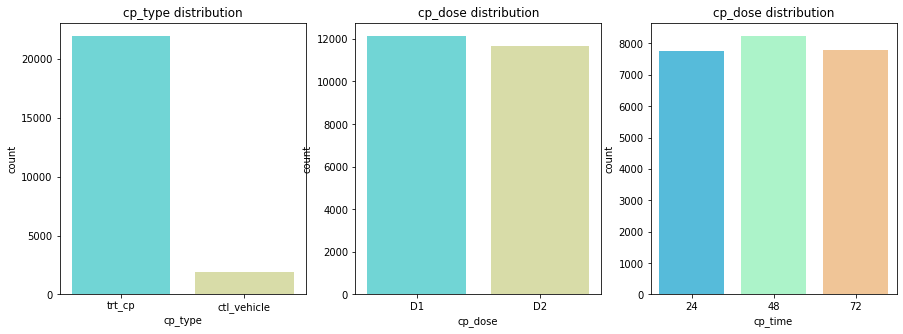

In [8]:
fig, axes = plt.subplots(1, 3,figsize=(15,5))
sns.countplot(x='cp_type', data=train_features, palette='rainbow', alpha=0.75,ax=axes[0]).set_title("cp_type distribution")
sns.countplot(x='cp_dose', data=train_features, palette='rainbow', alpha=0.75,ax=axes[1]).set_title("cp_dose distribution")
sns.countplot(x='cp_time', data=train_features, palette='rainbow', alpha=0.75,ax=axes[2]).set_title("cp_dose distribution")
plt.show()

These three features are categorical features, cp_type and cp_dose have binary values while cp_time has three values.

#### 2 ) Cell viability features(c-features) 

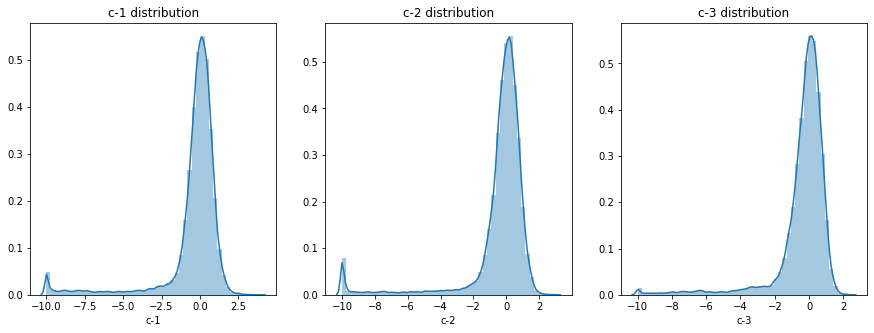

In [9]:
fig, axes = plt.subplots(1, 3,figsize=(15,5))
sns.distplot(train_features['c-1'], ax = axes[0]).set_title("c-1 distribution")
sns.distplot(train_features['c-2'], ax = axes[1]).set_title("c-2 distribution")
sns.distplot(train_features['c-3'], ax = axes[2]).set_title("c-3 distribution")
plt.show()

Above shows the distributions for the first three c-features. The c-features have similar distributions, with peak at 0 and majority of values between -2.5 and 2.5. Noticed that a small amount of values are concentrated at -10, which could indicate some error.

#### 3 ) Gene expression features(g-features) 

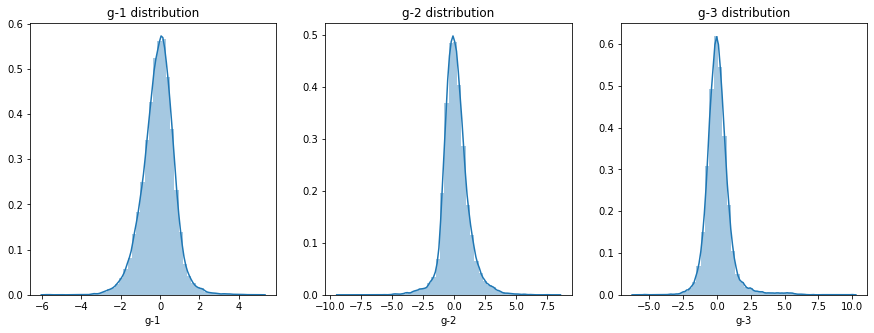

In [10]:
fig, axes = plt.subplots(1, 3,figsize=(15,5))
sns.distplot(train_features['g-1'], ax = axes[0]).set_title("g-1 distribution")
sns.distplot(train_features['g-2'], ax = axes[1]).set_title("g-2 distribution")
sns.distplot(train_features['g-3'], ax = axes[2]).set_title("g-3 distribution")
plt.show()

#### 4 ) Scored targets 

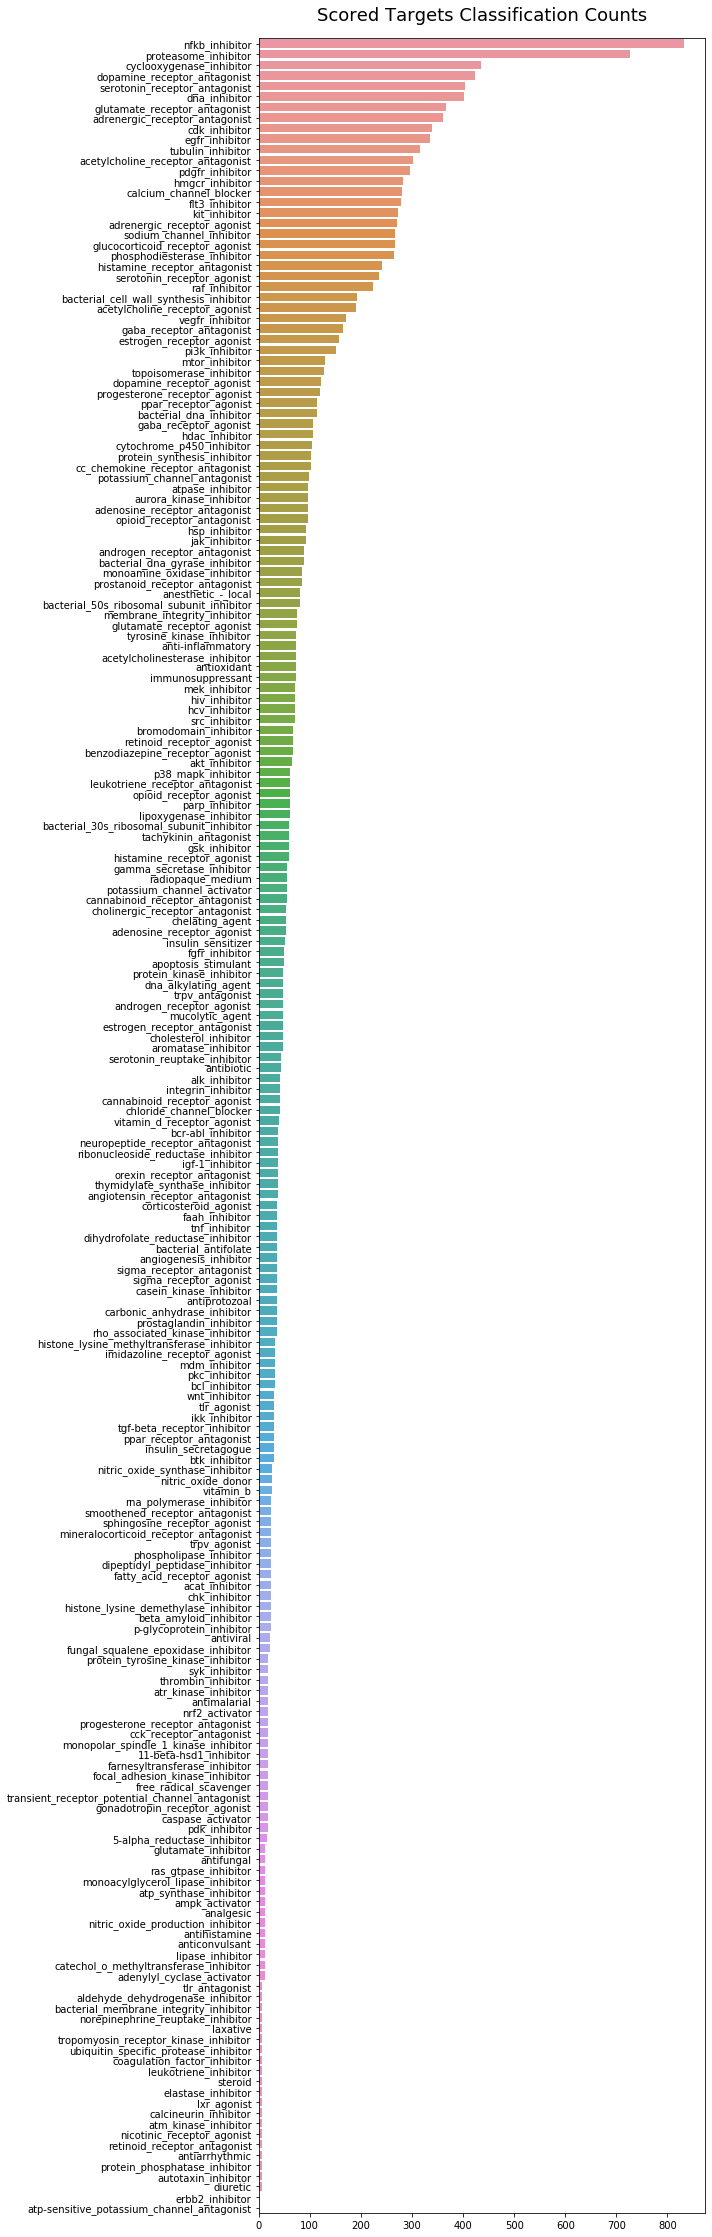

In [11]:
fig = plt.figure(figsize=(8, 40))
target_features_scored = list(train_targets_scored.columns[1:])
sns.barplot(x=train_targets_scored[target_features_scored].sum(axis=0).sort_values(ascending=False).values,
            y=train_targets_scored[target_features_scored].sum(axis=0).sort_values(ascending=False).index)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Scored Targets Classification Counts', size=18, pad=18)
plt.show()

## Preprocessing and Data Cleaning

### Restructure data to make prediction task easier

##### Merge train_targets_scored with the train_features

In [12]:
train_data = train_features.merge(train_targets_scored, how = "left", on = "sig_id") # merges training features and targets
train_data.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test_features.head() #head of merged data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


##### Change columns with strings to ints

In [15]:
def convert_str_int(data, col, val):
    "Converts columns with binary categorical values to integers"
    data[col] = (data[col] == val).astype(int)
    return data
train_data = convert_str_int(train_data, "cp_type", "trt_cp") #Converts strings to integers for "cp_type" and "trt_cp"
train_data = convert_str_int(train_data, "cp_dose", "D1") #Converts strings to integers for "cp_dose" and "D1"
train_data.head()


test_features = convert_str_int(test_features,"cp_type", "trt_cp") # Converts "cp_type" and "trt_cp" to int in test data
test_features = convert_str_int(test_features,"cp_dose", "D1") # Converts "cp_dose" and "D1" to int in test data
test_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,1,24,1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,1,72,1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,0,24,1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,1,24,0,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,1,48,1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


##### Split into Training and Development sets

In [16]:
train, dev = train_test_split(train_data, random_state = 42, 
                              test_size = 0.2, shuffle = True) # Divides data into training and develop

train = train.drop(columns =["sig_id"]) #drops id column
dev = dev.drop(columns =["sig_id"]) #drops id column

##### Pull out features and labels

In [17]:
X_train = train.loc[:, "cp_type":"c-99"] #Selects covariates for train data
Y_train = train.loc[:, "5-alpha_reductase_inhibitor":"wnt_inhibitor"] #Selects Y variables
X_dev = dev.loc[:, "cp_type":"c-99"] # Selects covariates for development data 
Y_dev = dev.loc[:, "5-alpha_reductase_inhibitor":"wnt_inhibitor"] #Selects Y variables 

## Prediction and Evaluation Metric

For every sig_id we will be predicting the probability that the sample had a positive response for each target. For N sig_id rows and M targets, we will be making N×M predictions. The predictions will be evaluated by the log loss:

\begin{align}
loss = - \frac{1}{M}\sum_{m=1}^M \frac{1}{N}\sum_{i=1}^{N}[y_{i,m}log(\hat{y}_{i,m})+(1-y_{i,m})log(1-\hat{y}_{i,m})]
\end{align}where:
- N is the number of sig_id observations in the test data (i=1,…,N)
- M is the number of scored MoA targets (m=1,…,M)
- ŷ i,m is the predicted probability of a positive MoA response for a sig_id
- yi,m is the ground truth, 1 for a positive response, 0 otherwise
- log() is the natural logarithm

## For baseline, select one interesting outcome variable and fit a model

#### Select Outcome Variable

##### Select column with highest sum

In [18]:
def top_sum_col(df):
    "Finds Column with highest columnwise sum"
    df_sum = df.sum().to_frame().reset_index()
    df_sum = df_sum.sort_values(by=0,ascending=False, inplace=False).head(1)
    top_cols = df_sum['index'].tolist()
    return df[top_cols]
top_col_train = top_sum_col = top_sum_col(Y_train) # Selects column with highest columnwise sum in training data
top_col_dev = Y_dev['nfkb_inhibitor'] #select same colum

##### Resample to reduce Imbalance

In [19]:
def resample_data(X_data, Y_data):
    "Resamples data to correct imbalance"
    X = pd.concat([X_data, Y_data], axis = 1)
    no_activate = X[X['nfkb_inhibitor']==0]
    activate = X[X['nfkb_inhibitor']==1]
    upsampled = resample(activate, replace = True, 
                            n_samples = len(no_activate),
                            random_state = 34)
    upsampled = pd.concat([no_activate, upsampled])
    return upsampled
upsampled_train_data = resample_data(X_train, top_col_train) #upasamples the training data
upsampled_dev_data = resample_data(X_dev, Y_dev) #upsamples development data
print(upsampled_train_data['nfkb_inhibitor'].value_counts())#Now the distribution is equal
X_upsamp_train = upsampled_train_data.loc[:, "cp_type":"c-99"] #reselect X vars for train
Y_upsamp_train = upsampled_train_data['nfkb_inhibitor'] #upsampled Y train
X_upsamp_dev = upsampled_dev_data.loc[:, "cp_type":"c-99"] #upsampled X dev
Y_upsamp_dev = upsampled_dev_data['nfkb_inhibitor']


1    18372
0    18372
Name: nfkb_inhibitor, dtype: int64


#### Normalize the data

In [20]:
def scaling(D):
    "Scales the data to have range between 0 and 1"
    m_m_scaler = MinMaxScaler()
    data = m_m_scaler.fit_transform(D)
    return data
X_upsamp_train = scaling(X_upsamp_train) #normalizes train data
X_upsamp_dev = scaling(X_upsamp_dev) #normalizes development data

#### Decision Tree Model and Loss Function

##### Fit decision tree model on upsampled data and evaluate on dev set

In [21]:
def mean_column_logloss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, (1 - 1e-15))
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def decision_tree(X_train, Y_train, X_dev, Y_dev):
    for i in range(2, 50, 5):
        clf = DecisionTreeClassifier(max_depth = i, splitter = 'best')
        clf.fit(X_train, Y_train)
        Y_hat = clf.predict(X_dev)
        print(mean_column_logloss(Y_dev, Y_hat))
decision_tree(X_upsamp_train, Y_upsamp_train, X_upsamp_dev, Y_upsamp_dev) #fits decision tree model

2.551080292620633
3.3077932645486956
4.34920192330787
5.060961086959288
4.967307485937725
5.469277123143119
5.750238273104741
5.6116312974276985
4.903617771347622
6.342120123247784


## Includes all outcome variables

### Functions to upsample multi-label data

Note: The original versions of the functions in the cell below, before any modifications, were created here: https://www.kaggle.com/yassinealouini/mlsmote-for-moa

In [22]:
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices
def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [23]:
X_sub_train, y_sub_train = get_minority_samples(X_train, Y_train) #gets minority samples of dataframes
X_train_up, Y_train_up = MLSMOTE(X_sub_train, y_sub_train, 500, 5) #upsamples Ys. only 500 values of 4763 are used

X_sub_dev, Y_sub_dev = get_minority_samples(X_dev, Y_dev) #gets minority samples of dataframes
X_dev_up, Y_dev_up = MLSMOTE(X_sub_dev, Y_sub_dev, 500, 5)#only 500 of 4763 are being used to save time

In [24]:
decision_tree_pipeline = Pipeline([
                ('clf', DecisionTreeClassifier(max_depth = 2, splitter= 'best')) #fits decision tree pipeline
            ]) 
categories = list(Y_train.columns.values) # pulls columns out
for category in categories:
    print('**Processing {} comments...**'.format(category))
    decision_tree_pipeline.fit(X_train_up, Y_train_up[category])
    # calculating log loss
    prediction = decision_tree_pipeline.predict(X_dev_up)
    print('Log Loss is:', mean_column_logloss(Y_dev_up[category], prediction))

**Processing 5-alpha_reductase_inhibitor comments...**
Log Loss is: 1.3815510557964268
**Processing 11-beta-hsd1_inhibitor comments...**
Log Loss is: 3.2467041513314374
**Processing acat_inhibitor comments...**
Log Loss is: 4.904507847272174
**Processing acetylcholine_receptor_agonist comments...**
Log Loss is: 9.99200722162641e-16
**Processing acetylcholine_receptor_antagonist comments...**
Log Loss is: 0.13815510557964292
**Processing acetylcholinesterase_inhibitor comments...**
Log Loss is: 0.6907915198468175
**Processing adenosine_receptor_agonist comments...**
Log Loss is: 0.5526204223185711
**Processing adenosine_receptor_antagonist comments...**
Log Loss is: 9.99200722162641e-16
**Processing adenylyl_cyclase_activator comments...**
Log Loss is: 0.34539575992340893
**Processing adrenergic_receptor_agonist comments...**
Log Loss is: 1.7269420181352544
**Processing adrenergic_receptor_antagonist comments...**
Log Loss is: 6.009748691909316
**Processing akt_inhibitor comments...**
L

Log Loss is: 0.27631660793872714
**Processing gsk_inhibitor comments...**
Log Loss is: 9.99200722162641e-16
**Processing hcv_inhibitor comments...**
Log Loss is: 9.99200722162641e-16
**Processing hdac_inhibitor comments...**
Log Loss is: 9.99200722162641e-16
**Processing histamine_receptor_agonist comments...**
Log Loss is: 9.99200722162641e-16
**Processing histamine_receptor_antagonist comments...**
Log Loss is: 9.99200722162641e-16
**Processing histone_lysine_demethylase_inhibitor comments...**
Log Loss is: 1.0361648910421806
**Processing histone_lysine_methyltransferase_inhibitor comments...**
Log Loss is: 0.8289370302572979
**Processing hiv_inhibitor comments...**
Log Loss is: 1.5197173557400927
**Processing hmgcr_inhibitor comments...**
Log Loss is: 9.99200722162641e-16
**Processing hsp_inhibitor comments...**
Log Loss is: 9.99200722162641e-16
**Processing igf-1_inhibitor comments...**
Log Loss is: 3.3848464633521966
**Processing ikk_inhibitor comments...**
Log Loss is: 1.51971575

Log Loss is: 0.4144749119080909
**Processing vegfr_inhibitor comments...**
Log Loss is: 2.0032490309048185
**Processing vitamin_b comments...**
Log Loss is: 0.4835508655030515
**Processing vitamin_d_receptor_agonist comments...**
Log Loss is: 0.6907915198468175
**Processing wnt_inhibitor comments...**
Log Loss is: 3.2466721674342294


## Reduce Dimensionality with PCA

In [33]:
train_pca = train_data.drop(columns =["sig_id"]) #drops id column from train data
test_pca = test_features.drop(columns =["sig_id"]) #drops id column from test data

##### Pull out features and labels

In [34]:
X_train_2 = train_pca.loc[:, "cp_type":"c-99"] #selects desired covariates in train data
X_test = test_pca.loc[:, "cp_type":"c-99"] # selects desired covariates in test data
print(len(X_train_2))
Y_train = train_pca.loc[:, "5-alpha_reductase_inhibitor":"wnt_inhibitor"] #groups X and Y train data together
print(len(Y_train))
print(len(X_test))

23814
23814
3982


In [35]:
def pca(train,test):
    pca = PCA(n_components=80)
    pca = pca.fit(train)
    print(sum(pca.explained_variance_ratio_))
    return pca.fit_transform(train), pca.fit_transform(test)
X_train_pca, X_test_pca = pca(X_train_2,X_test) #performs PCA on train and test data
X_train_pca.shape
X_train_pca = pd.DataFrame(X_train_pca)
train_data_pca = pd.concat([X_train_pca, Y_train], axis = 1) #concat X and Y back together
train_pca, dev_pca = train_test_split(train_data_pca, random_state = 42, 
                              test_size = 0.2, shuffle = True)

0.7957184251719335


##### Split into X and Y matrices

In [36]:
X_train_pca = train_pca.iloc[:, 0:80] #X train PCA
Y_train_pca = train_pca.loc[:, "5-alpha_reductase_inhibitor":"wnt_inhibitor"] #Y train PCA
X_dev_pca = dev_pca.iloc[:, 0:80] #X dev pca
Y_dev_pca = dev_pca.loc[:, "5-alpha_reductase_inhibitor":"wnt_inhibitor"] #Y dev pca

In [37]:
decision_tree_pipeline = Pipeline([
                ('clf', DecisionTreeClassifier(max_depth = 2, splitter= 'best'))
            ]) 
categories = list(Y_train_pca.columns.values)
lst = []
for category in categories:
    print('**Processing {} comments...**'.format(category))
    decision_tree_pipeline.fit(X_train_pca, Y_train_pca[category])
    # calculating log loss
    prediction = decision_tree_pipeline.predict(X_dev_pca)
    log_loss = mean_column_logloss(Y_dev_pca[category], prediction)
    print('Log Loss is:', log_loss)
    lst.append(log_loss)
print(f"The average log loss is {sum(lst)/len(lst)}")

    

**Processing 5-alpha_reductase_inhibitor comments...**
Log Loss is: 0.029005900814537775
**Processing 11-beta-hsd1_inhibitor comments...**
Log Loss is: 0.014502950407269448
**Processing acat_inhibitor comments...**
Log Loss is: 0.02900590081453787
**Processing acetylcholine_receptor_agonist comments...**
Log Loss is: 0.2900590081453761
**Processing acetylcholine_receptor_antagonist comments...**
Log Loss is: 0.44959163050218165
**Processing acetylcholinesterase_inhibitor comments...**
Log Loss is: 0.13052655366541938
**Processing adenosine_receptor_agonist comments...**
Log Loss is: 0.021754425610903325
**Processing adenosine_receptor_antagonist comments...**
Log Loss is: 0.14502967194953678
**Processing adenylyl_cyclase_activator comments...**
Log Loss is: 9.99200722162641e-16
**Processing adrenergic_receptor_agonist comments...**
Log Loss is: 0.3988311361998922
**Processing adrenergic_receptor_antagonist comments...**
Log Loss is: 0.5003517890507738
**Processing akt_inhibitor comment

Log Loss is: 0.07251475203634423
**Processing glutamate_receptor_antagonist comments...**
Log Loss is: 0.5801180162907522
**Processing gonadotropin_receptor_agonist comments...**
Log Loss is: 0.007251475203634485
**Processing gsk_inhibitor comments...**
Log Loss is: 0.09426917764724756
**Processing hcv_inhibitor comments...**
Log Loss is: 0.07251475203634417
**Processing hdac_inhibitor comments...**
Log Loss is: 0.10877212805451617
**Processing histamine_receptor_agonist comments...**
Log Loss is: 0.07251475203634423
**Processing histamine_receptor_antagonist comments...**
Log Loss is: 0.3625740959354175
**Processing histone_lysine_demethylase_inhibitor comments...**
Log Loss is: 0.04350901909865515
**Processing histone_lysine_methyltransferase_inhibitor comments...**
Log Loss is: 0.029005900814537845
**Processing hiv_inhibitor comments...**
Log Loss is: 0.0870178703204616
**Processing hmgcr_inhibitor comments...**
Log Loss is: 0.413334086607161
**Processing hsp_inhibitor comments...**

Log Loss is: 9.99200722162641e-16
**Processing trpv_agonist comments...**
Log Loss is: 0.029005900814538056
**Processing trpv_antagonist comments...**
Log Loss is: 0.07251475203634411
**Processing tubulin_inhibitor comments...**
Log Loss is: 0.47134974940375557
**Processing tyrosine_kinase_inhibitor comments...**
Log Loss is: 0.10152065285088184
**Processing ubiquitin_specific_protease_inhibitor comments...**
Log Loss is: 0.007251643080483746
**Processing vegfr_inhibitor comments...**
Log Loss is: 0.268304582534473
**Processing vitamin_b comments...**
Log Loss is: 0.02175459348775268
**Processing vitamin_d_receptor_agonist comments...**
Log Loss is: 0.07251475203634414
**Processing wnt_inhibitor comments...**
Log Loss is: 0.04350885122180653
The average log loss is 0.11296126387251947


## Now a more advanced model

In [38]:
def get_model(ip_shape,op_shape):
    """
    Tensor Flow neural network function. It has 4 layers with relu activation
    and a dropout set to prevent over fitting
    """
    tf.random.set_seed(36) #sets random seed for reproducible results
    model  = tf.keras.Sequential([
        layers.Dense(ip_shape*2,input_shape=(ip_shape,)), #dense layer to innitialize
        layers.BatchNormalization(),
        layers.Activation('relu'), #relu activation
        layers.Dropout(.4),
        layers.Dense(ip_shape*2,input_shape=(ip_shape,)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(.4),
        layers.Dense(ip_shape*3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(.3),
        layers.Dense(op_shape,activation='softmax')
        ])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics='accuracy') # compiles model
    return model

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, #adds early stopping parameter
  patience=3)

In [40]:
model = get_model(X_train_pca.shape[1],Y_train_pca.shape[1]) #runs neural network on pca data
history = model.fit(X_train_pca,Y_train_pca,validation_data=(X_dev_pca,Y_dev_pca),epochs=50,batch_size=128,verbose=0,
                    callbacks=[early_stop]) # fits tensorflow model
y_pred = model.predict(X_dev_pca)

log_loss_current = mean_column_logloss(Y_dev_pca,y_pred) #log loss for tensor flow algorithm
print(len(Y_dev_pca))
print("Log loss for each feature:")
print(log_loss_current,"\n")
print("Mean Log_Loss",sum(log_loss_current)/len(log_loss_current))

4763
Log loss for each feature:
5-alpha_reductase_inhibitor              0.006341
11-beta-hsd1_inhibitor                   0.004036
acat_inhibitor                           0.006849
acetylcholine_receptor_agonist           0.048020
acetylcholine_receptor_antagonist        0.068413
                                           ...   
ubiquitin_specific_protease_inhibitor    0.000530
vegfr_inhibitor                          0.033436
vitamin_b                                0.004654
vitamin_d_receptor_agonist               0.014345
wnt_inhibitor                            0.010157
Length: 206, dtype: float32 

Mean Log_Loss 0.016681631944327785


##### Reformat the data for submission to Kaggle

In [42]:
pred = model.predict(X_test_pca) #predicts onto test data for kaggle submission
cols = sample_sub.drop(['sig_id'],axis=1).columns #drops id column
sub = pd.DataFrame(data=pred) #converts back to data frame
sub.columns = cols #columns for dataset
sub.set_index(test_index,inplace=True) #sets index so accuracy calculation is correct
sub.sort_index(inplace=True) #keeps index consistent for accuracy measurement 
sub.insert(0,'sig_id',sample_sub['sig_id']) # reinserts id column
sub.to_csv('submission.csv', index=False) #converts to csv for kaggle
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000228,0.002841,0.002876,0.006199,0.024354,0.003437,0.003715,0.008511,0.000079,...,0.000417,0.004058,0.002801,0.057755,0.010103,0.000229,0.029516,0.002352,0.002250,0.000692
1,id_001897cda,0.008938,0.002026,0.001398,0.010702,0.021884,0.009730,0.005784,0.004004,0.003058,...,0.000448,0.002729,0.004489,0.001658,0.002128,0.002453,0.002170,0.001007,0.001099,0.002278
2,id_002429b5b,0.000332,0.001892,0.001675,0.003123,0.009719,0.002750,0.003887,0.008367,0.000578,...,0.000294,0.007310,0.002597,0.031994,0.017734,0.000567,0.025888,0.001999,0.001456,0.001039
3,id_00276f245,0.003258,0.005291,0.001254,0.019120,0.042886,0.004238,0.004826,0.008911,0.000140,...,0.000671,0.002389,0.002577,0.006373,0.001507,0.003546,0.001713,0.002269,0.004051,0.001225
4,id_0027f1083,0.000084,0.000232,0.002966,0.016861,0.028333,0.003776,0.005239,0.011312,0.000455,...,0.000311,0.000181,0.005169,0.000353,0.003667,0.000041,0.007721,0.004774,0.004977,0.010301
